env: OPENCV_IO_ENABLE_OPENEXR=1


c:\Users\alexa\.conda\envs\pad11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
INFO:art.config:set ART_DATA_PATH to C:\Users\alexa\.art\data
INFO:art.estimators.classification.pytorch:Inferred 5 hidden layers on PyTorch classifier.


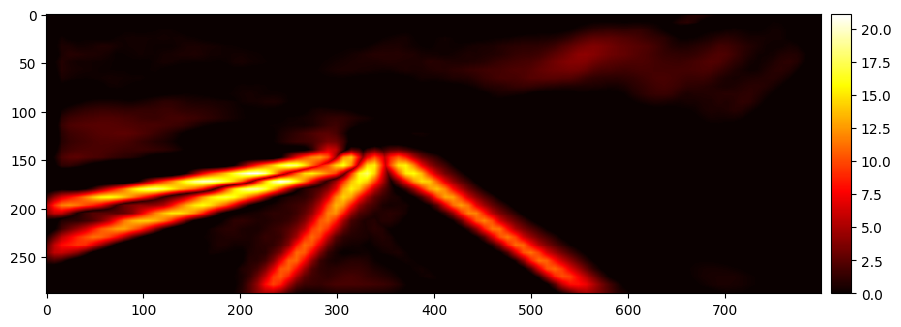

In [1]:
%env OPENCV_IO_ENABLE_OPENEXR=1
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from PIL import Image
import torch
import numpy as np
from matplotlib import pyplot as plt
from inference_pytorch import PyTorchPipeline
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2

model = "scnn"
model_path = "../resnet50_scnn_culane_custom_20240813.pt"
image = cv2.imread("sample.exr", cv2.IMREAD_UNCHANGED)
image_size = image.shape[:2][::-1]
model_in = image.transpose(2, 0, 1)#.astype(np.float32) / 255.0

pipeline_base = PyTorchPipeline(targeted=True, patch_size=(80, 80), 
                                        max_iterations=200,
                                        model=model,
                                        model_path=model_path)

# model_in = torch.ByteTensor(torch.ByteStorage.from_buffer(image.tobytes()))
# model_in = model_in.view(image_size[1], image_size[0], image.shape[2])
# model_in = (
#     model_in.permute((2, 0, 1)).contiguous().float().div(255).unsqueeze(0).numpy()
# )

# import pickle
# with open("../camera_observations/270_model_input.pkl", "rb") as f:
#     model_in = pickle.load(f)

def get_probmap_images(probmaps, image_size):
    prob_maps = torch.nn.functional.interpolate(probmaps['out'], 
                                                size=(image_size[1], image_size[0]), mode='bilinear', align_corners=True)
    prob_maps_softmax = prob_maps.detach().clone().softmax(dim=1)
    
    merged = np.zeros_like(prob_maps[0][1].detach().cpu().numpy())
    merged_softmax = np.zeros_like(prob_maps_softmax[0][1].detach().cpu().numpy())

    for i, lane in enumerate(prob_maps[0]):
        if i == 0: # skip first iteration (background class)
            continue
        pred = lane.detach().cpu().numpy()
        pred_softmax = prob_maps_softmax[0][i].detach().cpu().numpy()
        merged = np.maximum(merged, pred)
        merged_softmax = np.maximum(merged_softmax, pred_softmax)

    im = merged
    im_softmax = merged_softmax

    return im, im_softmax


results = pipeline_base.model(torch.from_numpy(model_in).unsqueeze(0).to(pipeline_base.device))

im, im_softmax = get_probmap_images(results, image_size)

# show im side by side and softmax in the next line side by side
fig = plt.figure(figsize=(10, 5)); 
ax = fig.add_subplot(1, 1, 1)
img = ax.imshow(im, cmap='hot',  interpolation='nearest')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(img, cax=cax)

plt.savefig("probmap.pdf", format="pdf", bbox_inches="tight")

plt.show()


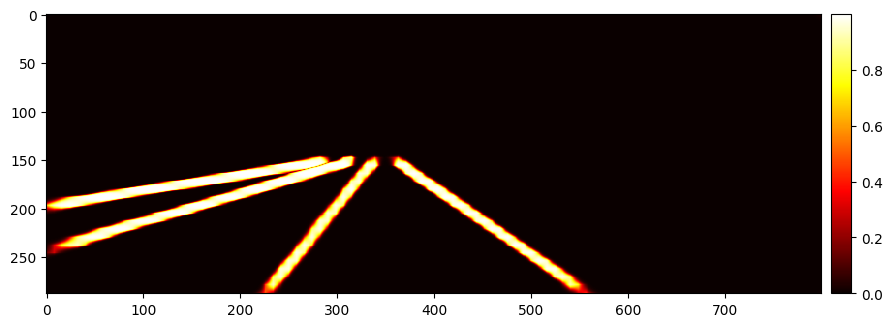

: 

In [ ]:
fig = plt.figure(figsize=(10, 5)); 
ax = fig.add_subplot(1, 1, 1)
img = ax.imshow(im_softmax, cmap='hot',  interpolation='nearest')

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(img, cax=cax)

plt.savefig("probmap_softmax.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
# save the image as png
im=cv2.imread("sample.exr",-1)
im=im*65535
im[im>65535]=65535
im=np.uint16(im)
cv2.imwrite("sample.png",im)

True

: 

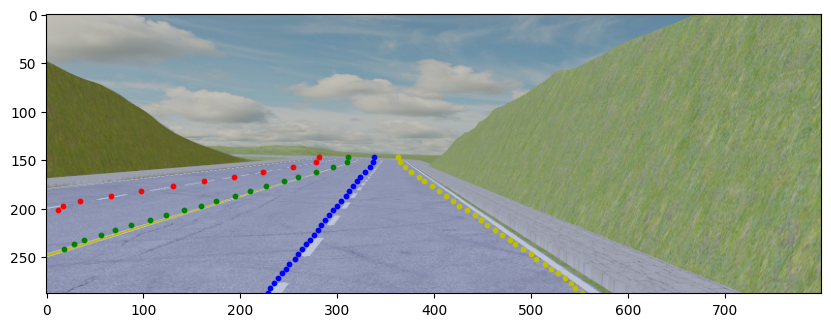

: 

In [ ]:
from attack.pytorch_auto_drive.utils.lane_det_utils import lane_as_segmentation_inference
from config import *

keypoints = lane_as_segmentation_inference(
            None,
            results,
            [input_sizes, input_sizes],
            gap,
            ppl,
            thresh,
            dataset,
            max_lane,
            forward=False,  # already called model
        )[0]


fig = plt.figure(figsize=(10, 5)); 
ax = fig.add_subplot(1, 1, 1)

# ax.imshow(infered_img)


ax.invert_yaxis()
out = cv2.cvtColor(image, cv2.COLOR_RGB2BGRA)
ax.imshow(out)
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for i, lane in enumerate(keypoints):
    for point in lane:
        ax.scatter(point[0], point[1], s=10, c=colors[i], marker='o')

plt.savefig("point_sampling.pdf", format="pdf", bbox_inches="tight")
plt.show()

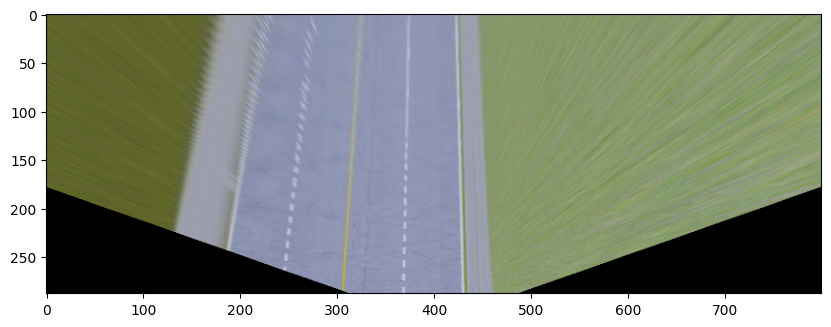

: 

In [ ]:
from lanefitting import Camera


config_1280x720 = {
    'fx': 1108.5125168440816, 
    'fy': 1108.512494908983, 
    'px': 640.0, 
    'py': 360.0, 
    'yaw': 90.0, 
    'pitch': 0.0, 
    'roll': 0.0, 
    'XCam': 0.0, 
    'YCam': 0.0, 
    'ZCam': 1.5
}
cam_big = Camera(config_1280x720)
image_big = np.array(cv2.cvtColor(cv2.imread("basic_1280_720.jpg"), cv2.COLOR_BGR2RGB))

def get_ipm_matrix(cam, image):
    height, width, _ = image.shape

    cam_height = 50.0
    x_offset = 35.0 # in driving direction

    outputRes = (int(2 * cam.config["py"]), int(2 * cam.config["px"]))
    dx = outputRes[1] / cam.config["fx"] * cam_height
    dy = outputRes[0] / cam.config["fy"] * cam_height
    pxPerM = (outputRes[0] / dx, outputRes[1] / dy)


    # setup mapping from street/top-image plane to world coords
    shift = (outputRes[0] / 2.0, outputRes[1] / 2.0) # was (outputRes[0] / 2.0, outputRes[1] / 2.0)
    shift = shift[0] + x_offset * pxPerM[0], shift[1] - cam.config["XCam"] * pxPerM[1]
    M = np.array([[1.0 / pxPerM[1], 0.0, -shift[1] / pxPerM[1]], [0.0, -1.0 / pxPerM[0], shift[0] / pxPerM[0]], [0.0, 0.0, 0.0], [0.0, 0.0, 1.0]])

    ipm = np.linalg.inv(cam.P.dot(M))
    return ipm

ipm_big = get_ipm_matrix(cam_big, image_big)

# warp the images
warped_big = cv2.warpPerspective(image_big, ipm_big, (image_big.shape[1], image_big.shape[0]))
warped_big = cv2.resize(warped_big, (image_size[0], image_size[1]))

# plot the warped images
fig = plt.figure(figsize=(10, 5)); 
ax = fig.add_subplot(1, 1, 1)
ax.imshow(warped_big)
plt.savefig("bev.pdf", format="pdf", bbox_inches="tight")
plt.show()


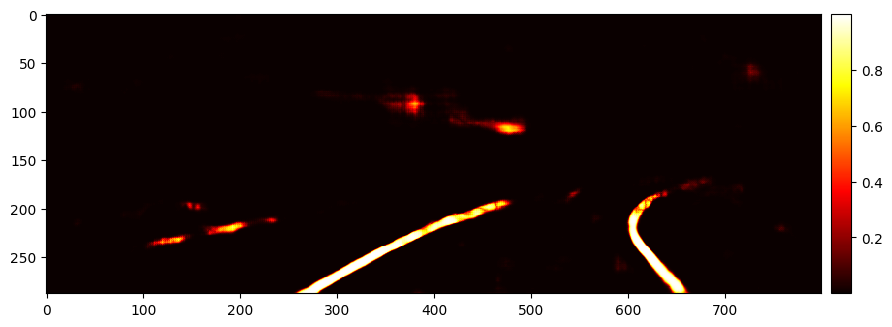

: 

In [ ]:
# Target Probmap
target=np.load("../attack/targets/turn_right.npy", allow_pickle=True).item()

im, im_softmax = get_probmap_images(target, image_size)

# show im side by side and softmax in the next line side by side
fig = plt.figure(figsize=(10, 5)); 
ax = fig.add_subplot(1, 1, 1)
img = ax.imshow(im_softmax, cmap='hot',  interpolation='nearest')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(img, cax=cax)

plt.savefig("target_probmap.pdf", format="pdf", bbox_inches="tight")

plt.show()

INFO:art.estimators.classification.pytorch:Inferred 5 hidden layers on PyTorch classifier.


Offset Center of original image:  -0.5552


RobustDPatch iteration: 100%|██████████| 200/200 [00:24<00:00,  8.24it/s, loss=0.26875976]


Offset Center of attacked image:  17.161


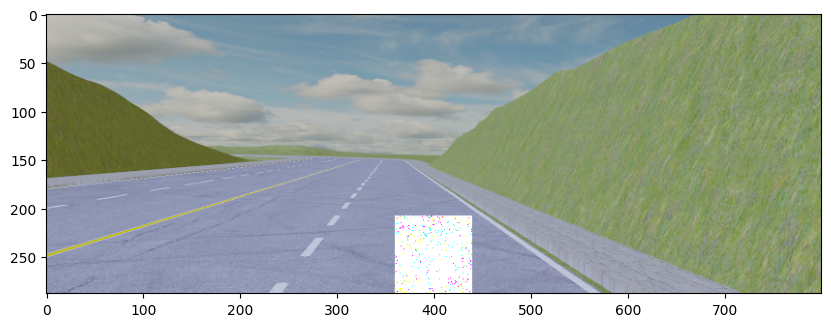

: 

In [ ]:
# Sample Patch attack

pipeline_resa = PyTorchPipeline(targeted=True, patch_size=(80, 80), 
                                        max_iterations=200,
                                        model="resa")

from lanefitting import get_offset_center

config_800x288 = {
    'fx': 692.82,
    'fy': 692.82, 
    'px': 400.0, 
    'py': 144.0, 
    'yaw': 90.0, 
    'pitch': 0.0, 
    'roll': 0.0, 
    'XCam': 0.0, 
    'YCam': 0.0, 
    'ZCam': 1.5
}


cam = Camera(config_800x288)
ipm_small = get_ipm_matrix(cam, image)

off_center, _, _ = get_offset_center(
    keypoints, (image_size[0], image_size[1]), ipm_small
)

print("Offset Center of original image: ", off_center)

m = torch.from_numpy(model_in).unsqueeze(0).to(pipeline_base.device)

patch = pipeline_resa.attack.generate(x=m.cpu().numpy(), y=target)[0]
patch_cuda= torch.from_numpy(patch).to(pipeline_resa.device)

x_1, y_1 = pipeline_resa.patch_location
x_2, y_2 = x_1 + patch.shape[2], y_1 + patch.shape[1]
m[0][:, y_1:y_2, x_1:x_2] = patch_cuda

# image with patch: m[0].cpu().numpy()
# plot image 
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
patched_image = m[0].cpu().numpy().transpose(1, 2, 0)
patched_image = cv2.cvtColor(patched_image, cv2.COLOR_BGR2RGB)
ax.imshow(patched_image)
plt.savefig("attack_input.pdf", format="pdf", bbox_inches="tight")

results_attack = pipeline_resa.model(m)
keypoints_attack = lane_as_segmentation_inference(
            None,
            results_attack,
            [input_sizes, input_sizes],
            gap,
            ppl,
            thresh,
            dataset,
            max_lane,
            forward=False,  # already called model
        )[0]

off_center_attack, _, _ = get_offset_center(
    keypoints_attack, (image_size[0], image_size[1]), ipm_small
)
print("Offset Center of attacked image: ", off_center_attack)


In [ ]:



m = torch.from_numpy(model_in).unsqueeze(0).to(pipeline_base.device)

patch = pipeline_resa.attack.generate(x=m.cpu().numpy(), y=target)[0]
patch_cuda= torch.from_numpy(patch).to(pipeline_resa.device)

x_1, y_1 = pipeline_resa.patch_location
x_2, y_2 = x_1 + patch.shape[2], y_1 + patch.shape[1]
m[0][:, y_1:y_2, x_1:x_2] = patch_cuda

# image with patch: m[0].cpu().numpy()
# plot image 
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
patched_image = m[0].cpu().numpy().transpose(1, 2, 0)
patched_image = cv2.cvtColor(patched_image, cv2.COLOR_BGR2RGB)
ax.imshow(patched_image)
plt.savefig("attack_input.pdf", format="pdf", bbox_inches="tight")

results_attack = pipeline_resa.model(m)
keypoints_attack = lane_as_segmentation_inference(
            None,
            results_attack,
            [input_sizes, input_sizes],
            gap,
            ppl,
            thresh,
            dataset,
            max_lane,
            forward=False,  # already called model
        )[0]

off_center_attack, _, _ = get_offset_center(
    keypoints_attack, (image_size[0], image_size[1]), ipm_small
)
print("Offset Center of attacked image: ", off_center_attack)


: 

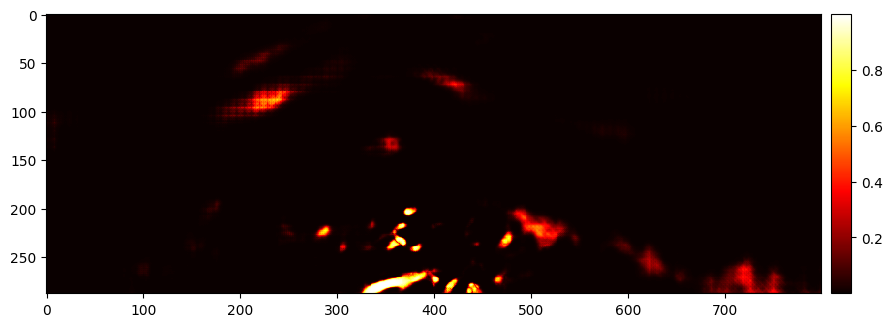

: 

In [ ]:
im, im_softmax = get_probmap_images(results_attack, image_size)

# show im side by side and softmax in the next line side by side
fig = plt.figure(figsize=(10, 5)); 
ax = fig.add_subplot(1, 1, 1)
img = ax.imshow(im_softmax, cmap='hot',  interpolation='nearest')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(img, cax=cax)

plt.savefig("attack_probmap.pdf", format="pdf", bbox_inches="tight")

plt.show()